# Model Evaluation  
  
Here we examine model performances from the previous step and choose the best model for each representation

In [1]:
import os
import re 
import ast
import random
import numpy as np
import pandas as pd  
  
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, f1_score, precision_score, recall_score


import matplotlib.pyplot as plt

from numpy import argmax, nanargmax

import seaborn as sns



## Directory setup

In [2]:
MODEL_TRAIN_DIR = "../data/02.model_training/"
SCREEN_DATA_DIR = "../data/01.prepare_training_data/"

OUTPUT_DIR = "../data/03.model_evaluation/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Read training output and determine best models

In [3]:
# Read performance data
performance_df = pd.read_csv(os.path.join(MODEL_TRAIN_DIR, "strain_performance.tsv.gz"), sep='\t')

# Add a column to identify each model
performance_df["experiment_id"] = performance_df["representation"].str.cat(performance_df["model"], sep="-")

# Gather the average performance of each configuration
performance_avgs = performance_df.groupby("experiment_id")["validation_prauc"].mean()

# Gather the highest PR-AUC for each representation
performance_avgs = performance_avgs.reset_index()
performance_avgs["representation"] = performance_avgs["experiment_id"].str.split("-").str[0]

mole_performance = performance_avgs[performance_avgs["representation"] == "MolE"]
mole_performance = mole_performance[mole_performance["validation_prauc"] == mole_performance["validation_prauc"].max()]

ecpf4_performance = performance_avgs[performance_avgs["representation"] == "ecfp4"]
ecpf4_performance = ecpf4_performance[ecpf4_performance["validation_prauc"] == ecpf4_performance["validation_prauc"].max()]

chemdesc_performance = performance_avgs[performance_avgs["representation"] == "chemDesc"]
chemdesc_performance = chemdesc_performance[chemdesc_performance["validation_prauc"] == chemdesc_performance["validation_prauc"].max()]

pd.concat([mole_performance, ecpf4_performance, chemdesc_performance]).sort_values("validation_prauc", ascending=False)

,experiment_id,validation_prauc,representation
3,MolE-model_3,0.700966,MolE
14,ecfp4-model_4,0.672382,ecfp4
5,chemDesc-model_0,0.660690,chemDesc


In [4]:
split_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_scaffold_split.tsv.gz"), index_col="prestwick_ID", sep='\t')

## Re-train models

### Functions for re-training

In [3]:
# Read data
representation_dict = {"MolE": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_mole_representation.tsv.gz"), index_col=0, sep='\t'),
"ecfp4": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_ecfp4_representation.tsv.gz"), index_col=0, sep='\t'),
"chemDesc": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_chemdesc_representation.tsv.gz"), index_col=0, sep='\t')}


split_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_scaffold_split.tsv.gz"), index_col="prestwick_ID", sep='\t')
screen_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_screening_results.tsv.gz"), index_col="prestwick_ID", sep='\t')

# Prepare strain one-hot-encoding
def prep_ohe(categories):
    """
    Prepare one-hot encoding for strain variables.

    This function creates a one-hot encoding representation of the provided categorical variables.
    It fits a OneHotEncoder to the categories and transforms them into a pandas DataFrame.

    Parameters:
    - categories (array-like): Array-like object containing categorical variables.

    Returns:
    - cat_ohe (pandas.DataFrame): DataFrame representing the one-hot encoded categorical variables.
    """

    ohe = OneHotEncoder(sparse=False)
    ohe.fit(pd.DataFrame(categories))
    cat_ohe = pd.DataFrame(ohe.transform(pd.DataFrame(categories)),
             index=categories, columns=ohe.categories_)
    
    return cat_ohe

def get_split(data_df, y_df =screen_df, splitter_df = split_df, split_strat = "split"):
    
    """
    Prepare data splits for training, validation, and testing.

    This function prepares the data splits for training, validation, and testing based on the given split strategy.
    It joins molecular features with taxonomic One-Hot Encoded (OHE) labels and separates the data into respective splits.

    Parameters:
    - data_df (pandas.DataFrame): DataFrame containing molecular features.
    - y_df (pandas.DataFrame): DataFrame containing labels.
    - splitter_df (pandas.DataFrame): DataFrame containing chemical IDs and split information.
    - split_strat (str, optional): Split strategy to use ("split" by default).

    Returns:
    - X_train (pandas.DataFrame): DataFrame containing features for training.
    - X_valid (pandas.DataFrame): DataFrame containing features for validation.
    - X_test (pandas.DataFrame): DataFrame containing features for testing.
    - y_train (numpy.ndarray): Array containing labels for training.
    - y_valid (numpy.ndarray): Array containing labels for validation.
    - y_test (numpy.ndarray): Array containing labels for testing.
    """
    
    # Get the chemicals in each split of data
    train_chems = splitter_df.loc[splitter_df[split_strat] == "train"].index
    validation_chems = splitter_df.loc[splitter_df[split_strat] == "valid"].index
    test_chems = splitter_df.loc[splitter_df[split_strat] == "test"].index

    # Prepare taxonomic OHE
    taxa_ohe = prep_ohe(y_df.columns) 


    # Format labels
    screen_melt = y_df.unstack().reset_index().rename(columns={0: "label",
                                                               "level_0": "taxa_name"})
    
    # Join molecular features and then join taxa OHE
    data_df.columns = [str(c) for c in data_df.columns]
    data_df = data_df.fillna(0)

    screen_feat = screen_melt.join(data_df, on="prestwick_ID")
    screen_feat = screen_feat.join(taxa_ohe, on="taxa_name")

    screen_feat["pred_id"] = screen_feat["prestwick_ID"].str.cat(screen_feat["taxa_name"], sep=":")
    screen_feat = screen_feat.set_index("pred_id")

    assert screen_feat.shape[0] == screen_melt.shape[0]


    # Gather train
    X_train = screen_feat.loc[screen_feat["prestwick_ID"].isin(train_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_train = screen_feat.loc[screen_feat["prestwick_ID"].isin(train_chems), ["label"]].values

    # Gather valid
    X_valid = screen_feat.loc[screen_feat["prestwick_ID"].isin(validation_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_valid = screen_feat.loc[screen_feat["prestwick_ID"].isin(validation_chems), ["label"]].values

    # Gather test
    X_test = screen_feat.loc[screen_feat["prestwick_ID"].isin(test_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_test = screen_feat.loc[screen_feat["prestwick_ID"].isin(test_chems), ["label"]].values

    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def get_performance_metrics(y_true, y_pred, y_score, split_name):

    """
    Compute performance metrics for a given data split.

    This function calculates various performance metrics including AUROC, AUPRC, and F1 score
    based on the true labels, predicted labels, and predicted scores.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - y_score (array-like): Predicted scores.
    - split_name (str): Name of the data split.

    Returns:
    - out_dict (dict): Dictionary containing computed performance metrics.
        Keys:
        - '{split_name}_auroc': Area Under the Receiver Operating Characteristic curve (AUROC) score.
        - '{split_name}_prauc': Area Under the Precision-Recall curve (AUPRC) score.
        - '{split_name}_f1': F1 score.
    """
    
    pr, rec, _ = precision_recall_curve(y_true, y_score[:, 1])

    out_dict = {f"{split_name}_auroc": roc_auc_score(y_true=y_true, y_score=y_score[:, 1]),
                f"{split_name}_prauc": auc(rec, pr),
                f"{split_name}_f1": f1_score(y_true=y_true, y_pred=y_pred)}
    
    pred_df = pd.DataFrame({"y_true": np.reshape(y_true, len(y_true)), "0": y_score[:, 0], "1": y_score[:, 1], "y_pred": y_pred})
    pred_df["split"] = split_name

    return out_dict, pred_df


# Function that trains the model
def prepare_estimator(representation, model_params, screen_df=screen_df, split_df=split_df, representation_dict = representation_dict):

    """
    Prepare an XGBoost classifier and evaluate its performance on a given dataset representation.

    This function prepares an XGBoost classifier with specified parameters and evaluates its performance
    on a specified dataset representation. It trains the model on the training set, evaluates it on
    the validation and test sets, and returns the trained model along with performance metrics.

    Parameters:
    - representation (str): Name of the dataset representation to use.
    - model_params (dict): Dictionary containing XGBoost parameters for model configuration.
    - screen_df (pandas.DataFrame, optional): DataFrame containing screening data (default is screen_df).
    - split_df (pandas.DataFrame, optional): DataFrame containing split information (default is split_df).
    - representation_dict (dict, optional): Dictionary containing different dataset representations (default is representation_dict).

    Returns:
    - model (XGBClassifier): Trained XGBoost classifier.
    - train_df (pandas.DataFrame): DataFrame containing performance metrics for the trained model.
    - split_preds (pandas.DataFrame): DataFrame containing evaluation predictions for validation and test sets.
    """

    # Prepare the model
    model = XGBClassifier(**model_params)

    # Gather the data 
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_split(representation_dict[representation], 
                                                                  screen_df, 
                                                                  split_df)

    # Train the model
    model.fit(X=X_train, y=y_train)

    # Perform evaluation to confirm performance

    # Validation
    print("At Validation")
    validation_proba = model.predict_proba(X=X_valid)
    validation_preds = model.predict(X=X_valid) 

    # Testing
    print("At Testing")
    test_proba = model.predict_proba(X=X_test)
    test_preds = model.predict(X=X_test)

    # Performance Metrics
    print("Gathering Results")
    validation_performance, validation_eval_preds = get_performance_metrics(y_true=y_valid, y_pred=validation_preds, y_score=validation_proba, split_name="validation")
    test_performance, test_eval_preds = get_performance_metrics(y_true=y_test, y_pred=test_preds, y_score=test_proba, split_name="test")

    performance_dict = {**validation_performance, **test_performance}

    train_df = pd.DataFrame(performance_dict, index=[0])

    validation_eval_preds["pred_id"] = X_valid.index
    test_eval_preds["pred_id"] = X_test.index
    split_preds = pd.concat([validation_eval_preds, test_eval_preds])
    
    
    return model, train_df, split_preds

### Gather best model parameters

In [11]:

# Get MolE model parameters
mole_model_params = performance_df.loc[performance_df["experiment_id"] == mole_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
mole_model_params = ast.literal_eval(mole_model_params)
mole_model_params["random_state"]=42

# Get ecpf4 model parameters
ecfp4_model_params = performance_df.loc[performance_df["experiment_id"] == ecpf4_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
ecfp4_model_params = ast.literal_eval(ecfp4_model_params)
ecfp4_model_params["random_state"]=42

# Get ecpf4 model parameters
chemdesc_model_params = performance_df.loc[performance_df["experiment_id"] == chemdesc_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
chemdesc_model_params = ast.literal_eval(chemdesc_model_params)
chemdesc_model_params["random_state"]=42

In [ ]:
mole_model, mole_metrics, mole_evalpreds = prepare_estimator("MolE", ecfp4_model_params)
mole_metrics

In [8]:
ecfp4_model, ecfp4_metrics, ecfp4_evalpreds = prepare_estimator("ecfp4", ecfp4_model_params)
ecfp4_metrics

At Validation
At Testing
Gathering Results


,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1
0,0.812104,0.65356,0.510998,0.83481,0.709667,0.644501


In [9]:
chemdesc_model, chemdesc_metrics, chemdesc_evalpreds = prepare_estimator("chemDesc", chemdesc_model_params)
chemdesc_metrics

At Validation
At Testing
Gathering Results


,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1
0,0.881516,0.66436,0.333649,0.891767,0.689418,0.463462


## Determine optimal score threshold

In [10]:
evalpreds_dict = {"MolE": mole_evalpreds, "ecfp4": ecfp4_evalpreds, "chemDesc": chemdesc_evalpreds}

# Gathers the optimized threshold from the validation set of predictions
def optimal_threshold(eval_df):
     
    """
    Determine the optimal threshold for classification based on F1 score.

    This function estimates the optimal threshold for classification by maximizing the F1 score.
    It calculates the F1 score for different thresholds based on precision-recall curve and returns
    the threshold corresponding to the maximum F1 score.

    Parameters:
    - eval_df (pandas.DataFrame): DataFrame containing evaluation predictions.

    Returns:
    - optimal_threshold (float): Optimal threshold for classification.
    """

    # Gather the predictions from validation
    validation_preds = eval_df.loc[eval_df["split"] == "validation"]

    # Estimate prediction recall curve
    precision, recall, thresholds = precision_recall_curve(validation_preds["y_true"], validation_preds["1"])

    # Estimate the F1 score
    f1_scores = (2 * precision * recall) / (precision + recall)

    # Get the optimal threshold
    optimal_idx = nanargmax(f1_scores)
    
    return thresholds[optimal_idx]

# Uses the provided threshold to estimate the performance metrics
def prc_metrics(prediction_data, split, threshold=0.5):

    """
    Calculate precision, recall, and F1 score metrics based on prediction data for a specific split.

    This function calculates precision, recall, and F1 score metrics based on prediction data
    for a specific split using a given threshold for classification.

    Parameters:
    - prediction_data (pandas.DataFrame): DataFrame containing prediction data.
    - split (str): Name of the split for which metrics are calculated.
    - threshold (float, optional): Threshold for classification (default is 0.5).

    Returns:
    - metric_dict (dict): Dictionary containing precision, recall, and F1 score metrics.
    """

    # Gather the predictions from the split
    pred_data = prediction_data[prediction_data["split"] == split].copy()

    # Determine positive predictions using threshold
    pred_data["y_pred"] = pred_data["1"].apply(lambda x: 1 if x >= threshold else 0)

    # Estimate metrics
    metric_dict = {f"{split}_fscore": f1_score(pred_data.y_true, pred_data.y_pred),
                   f"{split}_precision": precision_score(pred_data.y_true, pred_data.y_pred),
                   f"{split}_recall": recall_score(pred_data.y_true, pred_data.y_pred)}
    
    return metric_dict

# Gather optimized metrics
def optimized_metrics(representation, evalpreds_dict=evalpreds_dict):

    """
    Calculate optimized precision, recall, and F1 score metrics for a given dataset representation.

    This function calculates precision, recall, and F1 score metrics for a given dataset representation.
    It optimizes the threshold for classification using the validation set and computes metrics
    both for the optimized threshold and a baseline threshold of 0.5.

    Parameters:
    - representation (str): Name of the dataset representation.
    - evalpreds_dict (dict): Dictionary containing evaluation predictions for different representations.

    Returns:
    - combined_df (pandas.DataFrame): DataFrame containing optimized and baseline metrics for the representation.
    """

    # Gather the predictions from the representation
    eval_df = evalpreds_dict[representation]

    # Gather optimized threshold from validation set
    optimized_threshold = optimal_threshold(eval_df)

    # Gather optimized metrics
    validation_opt = prc_metrics(eval_df, "validation", optimized_threshold)
    test_opt = prc_metrics(eval_df, "test", optimized_threshold)
    
    # Aggregate into dataframe
    optimal_df = pd.DataFrame({**validation_opt, **test_opt}, index=[0])
    optimal_df["threshold"] = optimized_threshold
    optimal_df["score_type"] = "optimized"

    # Gather metrics from baseline
    validation_baseline = prc_metrics(eval_df, "validation", 0.5)
    test_baseline = prc_metrics(eval_df, "test", 0.5)

    baseline_df = pd.DataFrame({**validation_baseline, **test_baseline}, index=[1])
    baseline_df["threshold"] = 0.5
    baseline_df["score_type"] = "baseline"

    # Combine the dataframes
    combined_df = pd.concat([optimal_df, baseline_df])
    combined_df["representation"] = representation
    
    return combined_df


In [11]:
optimal_thresholds = pd.concat([optimized_metrics(r) for r in evalpreds_dict.keys()])
optimal_thresholds

/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


,validation_fscore,validation_precision,validation_recall,test_fscore,test_precision,test_recall,threshold,score_type,representation
0,0.635983,0.783505,0.535211,0.693260,0.730435,0.659686,0.043741,optimized,MolE
1,0.470275,0.963636,0.311033,0.595174,0.938028,0.435864,0.500000,baseline,MolE
0,0.595598,0.719269,0.508216,0.660348,0.832669,0.547120,0.209213,optimized,ecfp4
1,0.510998,0.915152,0.354460,0.644501,0.924205,0.494764,0.500000,baseline,ecfp4
0,0.617204,0.569444,0.673709,0.598907,0.514071,0.717277,0.067973,optimized,chemDesc
1,0.333649,0.866995,0.206573,0.463462,0.873188,0.315445,0.500000,baseline,chemDesc


Now that the optimal threshold is determined, we can view the effect on the precision recall curve

In [12]:
def gather_prc(representation, split, evalpreds_dict = evalpreds_dict):
    """
    Gather precision-recall curve data for a specific dataset representation and split.

    This function gathers precision, recall, and threshold data for a specific dataset representation
    and split from the evaluation predictions.

    Parameters:
    - representation (str): Name of the dataset representation.
    - split (str): Name of the split.
    - evalpreds_dict (dict): Dictionary containing evaluation predictions for different representations.

    Returns:
    - prc_df (pandas.DataFrame): DataFrame containing precision, recall, and threshold data for the representation and split.
    """

    # Gather the predictions from the representation
    eval_df = evalpreds_dict[representation]

    # Gather teh predictions from the split
    pred_data = eval_df[eval_df["split"] == split]

    # Estimate the precision recall curve
    precision, recall, thresholds = precision_recall_curve(pred_data.y_true, pred_data["1"])

    # Prepare the dataframe
    prc_df = pd.DataFrame({"precision": precision, "recall": recall, "threshold": np.insert(thresholds, 0, np.inf)})
    prc_df["representation"] = representation

    return prc_df
    

In [13]:
validation_prc = pd.concat([gather_prc(r, "validation") for r in evalpreds_dict.keys()])

<AxesSubplot:xlabel='recall', ylabel='precision'>

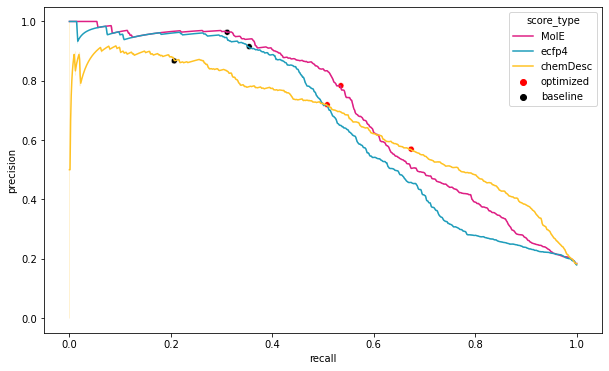

In [14]:
plt.figure(figsize=(10,6))


sns.lineplot(data=validation_prc.reset_index(), x="recall", y="precision", hue="representation",
             palette={"MolE":"#DE1F84", "ecfp4":"#1F9DBB", "chemDesc":"#FFC224"})

sns.scatterplot(data=optimal_thresholds, x="validation_recall", y="validation_precision", hue="score_type",
                palette={"optimized":"red", "baseline":"black"})

<AxesSubplot:xlabel='recall', ylabel='precision'>

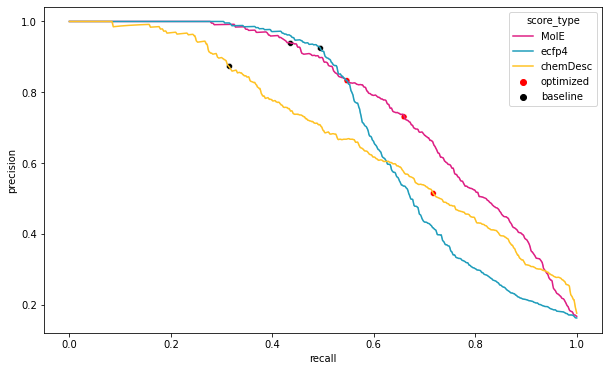

In [15]:
test_prc = pd.concat([gather_prc(r, "test") for r in evalpreds_dict.keys()])

plt.figure(figsize=(10,6))


sns.lineplot(data=test_prc.reset_index(), x="recall", y="precision", hue="representation",
             palette={"MolE":"#DE1F84", "ecfp4":"#1F9DBB", "chemDesc":"#FFC224"})

sns.scatterplot(data=optimal_thresholds, x="test_recall", y="test_precision", hue="score_type",
                palette={"optimized":"red", "baseline":"black"})

## Exploring Test Set

In [42]:
def gather_testpredictions(data_df, optimal_threshold):

    """
    Gather test predictions and pivot them into a table format.

    This function gathers test predictions from the provided DataFrame and determines positive predictions
    using the optimal threshold. It then pivots the predictions into a table format with Prestwick IDs as
    rows and strains as columns.

    Parameters:
    - data_df (pandas.DataFrame): DataFrame containing test predictions.
    - optimal_threshold (float): Optimal threshold for classification.

    Returns:
    - test_preds (pandas.DataFrame): DataFrame containing pivoted test predictions.
    """

    # Gather the predictions from the test set
    test_preds = data_df[data_df["split"] == "test"]

    # Determine positive predictions using threshold
    test_preds["y_pred"] = test_preds["1"].apply(lambda x: 1 if x >= optimal_threshold else 0)

    # Pivot into table
    test_preds[["prestwick_ID", "strain"]] = test_preds["pred_id"].str.split(":", expand=True)

    test_preds = test_preds.pivot(index="prestwick_ID", columns="strain", values="y_pred")

    return test_preds

In [48]:
# Gather optimized prediction on test set
mole_testpreds = gather_testpredictions(mole_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "MolE") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])

ecfp4_testpreds = gather_testpredictions(ecfp4_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "ecfp4") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])

chemDesc_testpreds = gather_testpredictions(chemdesc_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "chemDesc") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])                                                                                


# Gather the ground truth
test_truth = screen_df.loc[split_df[split_df["split"] == "test"].index]

/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Compare ground truth to predictions

In [4]:
# Read information
prestwick_info_complete = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "prestwick_library_screened.tsv.gz"), sep='\t', index_col=["prestwick_ID"])
prestwick_info = prestwick_info_complete[["chemical name"]]

In [63]:


true_agg = test_truth.sum(axis=1).to_frame().rename(columns={0: "true_count"})
mole_agg = mole_testpreds.sum(axis=1).to_frame().rename(columns={0: "MolE"})
ecfp4_agg = ecfp4_testpreds.sum(axis=1).to_frame().rename(columns={0: "ecfp4"})
chemdesc_agg = chemDesc_testpreds.sum(axis=1).to_frame().rename(columns={0: "chemDesc"})

# Join the dataframes
all_preds = prestwick_info.join(true_agg).join(mole_agg).join(ecfp4_agg).join(chemdesc_agg)

all_preds.loc[all_preds["true_count"] > 10]


,chemical name,true_count,MolE,ecfp4,chemDesc
prestwick_ID,,,,,
Prestw-1,Azaguanine-8,16.0,0.0,0.0,0.0
Prestw-1010,Talampicillin hydrochloride,34.0,29.0,34.0,34.0
Prestw-1024,Nifurtimox,35.0,38.0,40.0,37.0
Prestw-1028,Benzathine benzylpenicillin,35.0,30.0,40.0,39.0
Prestw-1040,Pyrvinium pamoate,20.0,31.0,0.0,27.0
Prestw-1045,Sertaconazole nitrate,18.0,28.0,38.0,33.0
Prestw-1067,Ticarcillin sodium,38.0,37.0,38.0,40.0
Prestw-1106,Meropenem,38.0,32.0,0.0,34.0
Prestw-1109,Rifabutin,40.0,40.0,40.0,40.0


Look at heatmaps

In [85]:
prest_id = "Prestw-1167"

# Gather the predictions
chem_predictions = pd.concat([chemDesc_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "chemDesc"}),
                              ecfp4_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "ecfp4"}),
                              mole_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "MolE"}),
                              test_truth.loc[prest_id].to_frame().transpose().rename(index={prest_id: "True_activity"})])

chem_predictions 

,Akkermansia muciniphila (NT5021),Bacteroides caccae (NT5050),Bacteroides fragilis (ET) (NT5033),Bacteroides fragilis (NT) (NT5003),Bacteroides ovatus (NT5054),Bacteroides thetaiotaomicron (NT5004),Bacteroides uniformis (NT5002),Bacteroides vulgatus (NT5001),Bacteroides xylanisolvens (NT5064),Bifidobacterium adolescentis (NT5022),...,Parabacteroides merdae (NT5071),Prevotella copri (NT5019),Roseburia hominis (NT5079),Roseburia intestinalis (NT5011),Ruminococcus bromii (NT5045),Ruminococcus gnavus (NT5046),Ruminococcus torques (NT5047),Streptococcus parasanguinis (NT5072),Streptococcus salivarius (NT5038),Veillonella parvula (NT5017)
chemDesc,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
ecfp4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MolE,0,0,1,1,1,0,1,1,0,1,...,1,1,1,1,1,1,0,1,1,0
True_activity,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:>

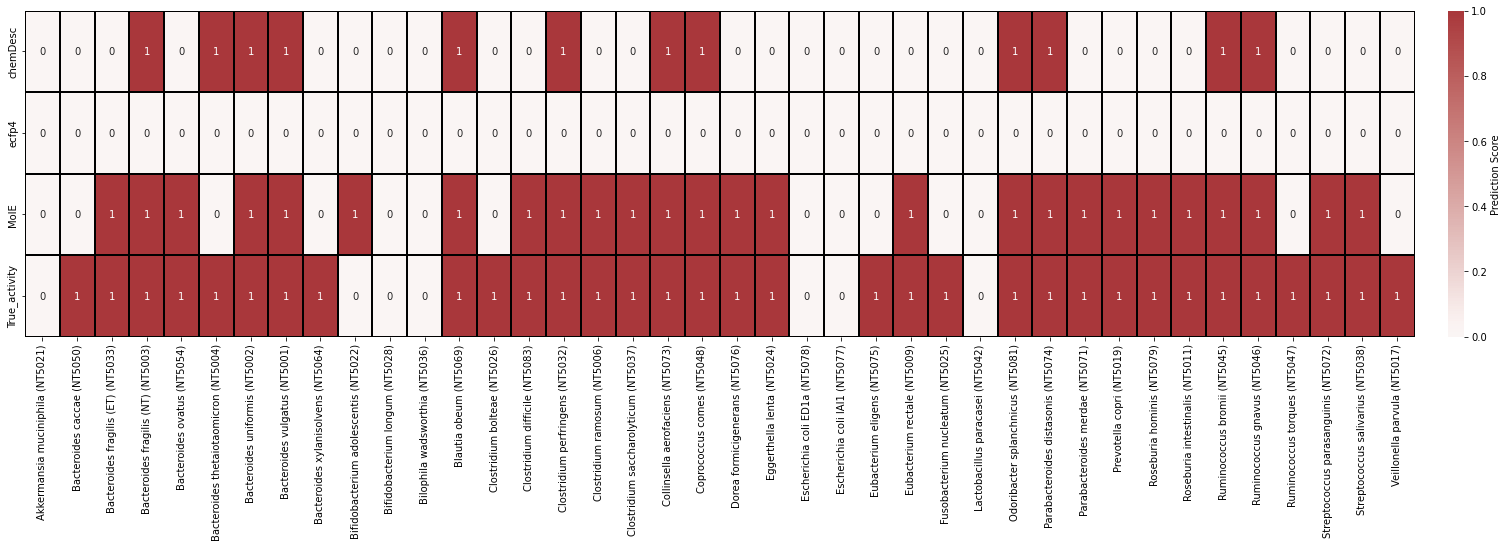

In [86]:
plt.figure(figsize=(30,6))

sns.heatmap(chem_predictions,cmap="vlag", robust=False, center=0, 
            linewidths=0.1, linecolor="black", annot=True,
            cbar_kws={"label": "Prediction Score", "pad": 0.02})

## Save models

In [5]:
import pickle
from datetime import datetime

In [88]:
#MolE
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"MolE-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(mole_model, file)


# ECFP4
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"ecfp4-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(ecfp4_model, file)


# Chemical Descriptor
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"chemDesc-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(chemdesc_model, file)

In [90]:
optimal_thresholds.to_csv(os.path.join(OUTPUT_DIR, "optimal_thresholds.tsv.gz"), sep='\t', index=False)

## Comparing test-set predictions  


In [6]:
# MolE model
with open(os.path.join(OUTPUT_DIR, "MolE-XGBoost-08.03.2024_14.20.pkl"), "rb") as file:
    mole_model = pickle.load(file)

# ECFP4 model
with open(os.path.join(OUTPUT_DIR, "ecfp4-XGBoost-08.03.2024_14.20.pkl"), "rb") as file:
    ecfp4_model = pickle.load(file)

# ChemDesc model
with open(os.path.join(OUTPUT_DIR, "chemDesc-XGBoost-08.03.2024_14.20.pkl"), "rb") as file:
    chemDesc_model = pickle.load(file)

# Read optimized parameters
optimized_parameters = pd.read_csv(os.path.join(OUTPUT_DIR, "optimal_thresholds.tsv.gz"), sep='\t')

Re-gather test set predictions

In [7]:
optimized_parameters

,validation_fscore,validation_precision,validation_recall,test_fscore,test_precision,test_recall,threshold,score_type,representation
0,0.635983,0.783505,0.535211,0.693260,0.730435,0.659686,0.043741,optimized,MolE
1,0.470275,0.963636,0.311033,0.595174,0.938028,0.435864,0.500000,baseline,MolE
2,0.595598,0.719269,0.508216,0.660348,0.832669,0.547120,0.209213,optimized,ecfp4
3,0.510998,0.915152,0.354460,0.644501,0.924205,0.494764,0.500000,baseline,ecfp4
4,0.617204,0.569444,0.673709,0.598907,0.514071,0.717277,0.067973,optimized,chemDesc
5,0.333649,0.866995,0.206573,0.463462,0.873188,0.315445,0.500000,baseline,chemDesc


In [8]:
def gather_predictions(model_obj, representation, opt_threshold):

    # Gather the test set data
    _, _, X_test, _, _, y_test = get_split(representation_dict[representation])

    # Gather the predictions
    test_preds = model_obj.predict(X=X_test)
    test_proba = model_obj.predict_proba(X=X_test)

    test_performance, test_eval_preds = get_performance_metrics(y_true=y_test, y_pred=test_preds, y_score=test_proba, split_name="test")

    test_eval_preds["y_pred_opt"] = test_eval_preds["1"].apply(lambda x: 1 if x >= opt_threshold else 0)

    # Add ID's
    test_eval_preds["pred_id"] = X_test.index
    test_eval_preds[["prestwick_ID", "strain"]] = test_eval_preds["pred_id"].str.split(":", expand=True)
    


    return test_performance, test_eval_preds

In [9]:
mole_test_performance, mole_test_preds = gather_predictions(mole_model, 
                                                            "MolE",
                                                            optimized_parameters.loc[(optimized_parameters["representation"]=="MolE") & 
                                                                                     (optimized_parameters["score_type"]=="optimized"), "threshold"].values[0])

ecfp4_test_performance, ecfp4_test_preds = gather_predictions(ecfp4_model, 
                                                            "ecfp4",
                                                            optimized_parameters.loc[(optimized_parameters["representation"]=="ecfp4") & 
                                                                                     (optimized_parameters["score_type"]=="optimized"), "threshold"].values[0])

chemDesc_test_performance, chemDesc_test_preds = gather_predictions(chemDesc_model, 
                                                            "chemDesc",
                                                            optimized_parameters.loc[(optimized_parameters["representation"]=="chemDesc") & 
                                                                                     (optimized_parameters["score_type"]=="optimized"), "threshold"].values[0])

In [10]:
true_count = mole_test_preds.groupby("prestwick_ID")["y_true"].sum().to_frame()
mole_count = mole_test_preds.groupby("prestwick_ID")["y_pred_opt"].sum().to_frame().rename(columns={"y_pred_opt":"MolE"})
ecfp4_count = ecfp4_test_preds.groupby("prestwick_ID")["y_pred_opt"].sum().to_frame().rename(columns={"y_pred_opt":"ECFP4"})
chemDesc_count = chemDesc_test_preds.groupby("prestwick_ID")["y_pred_opt"].sum().to_frame().rename(columns={"y_pred_opt":"chemDesc"})

count_comparison = true_count.join(mole_count).join(ecfp4_count).join(chemDesc_count).join(prestwick_info_complete[["chemical name", "target species"]])
count_comparison.head()


,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1,16,0,0,0,Azaguanine-8,human
Prestw-100,0,0,0,0,Nocodazole,human
Prestw-1003,0,0,0,0,Azapropazone,human
Prestw-1004,1,0,0,0,Meptazinol hydrochloride,human
Prestw-1005,10,10,5,7,Apramycin,veterinary: infections


Figure 3. It would be useful to include a visual representation of the agreement (or lack thereof) of predictions when using chemical descriptors, ECFP4 representations, and MolE representations. Figure 3e begins to show this for a single molecule, but it would be much more informative to summarize how the different models’ predictions (using different representations) compare. On which molecules do the models agree? On which molecules do the models disagree? Are different representations better/worse in different regions of chemical space?


In [11]:
from venny4py.venny4py import *

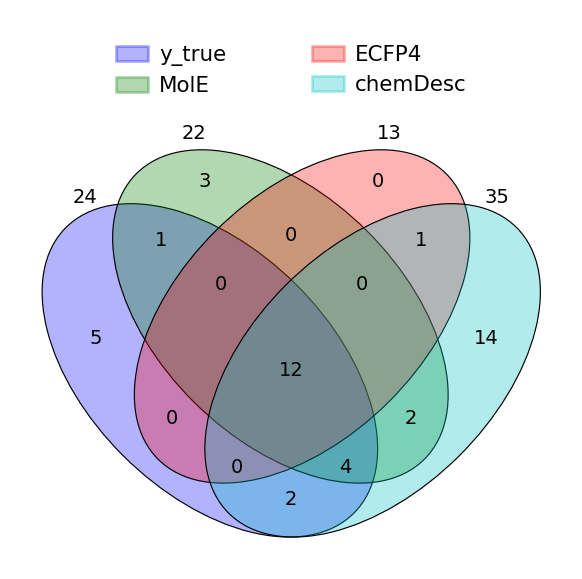

In [12]:
COUNT_CUTOFF = 10

set_dict_10 = {key:set(count_comparison[count_comparison[key] >= COUNT_CUTOFF].index.to_list()) for key in ["y_true", "MolE", "ECFP4", "chemDesc"]}

venny4py(sets=set_dict_10)


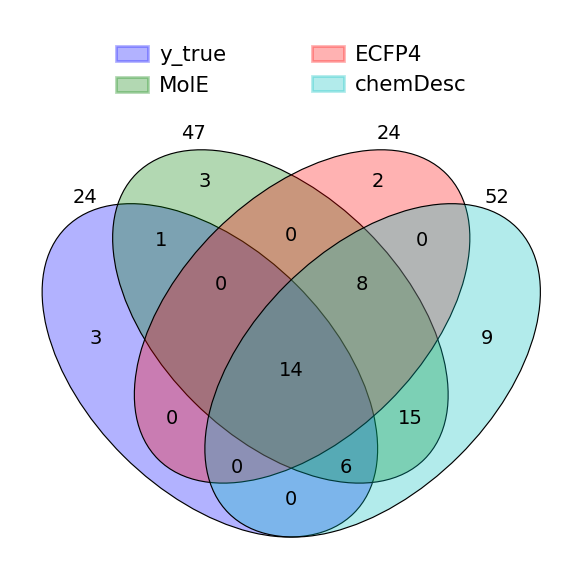

In [13]:
COUNT_CUTOFF = 1

set_dict_1 = {key:set(count_comparison[count_comparison[key] >= COUNT_CUTOFF].index.to_list()) for key in ["y_true", "MolE", "ECFP4", "chemDesc"]}
set_dict_1["y_true"] = set_dict_10["y_true"]


venny4py(sets=set_dict_1)

Molecules on which all models agree are actually all true positives! They mostly include compounds that target bacteria, and also some antifungal and antiparasitic compounds. 

In [14]:
count_comparison.loc[(count_comparison["ECFP4"]>=10) &
                     (count_comparison["MolE"]>=10) &
                     (count_comparison["chemDesc"]>=10)]

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1010,34,29,34,34,Talampicillin hydrochloride,bacteria
Prestw-1024,35,38,40,37,Nifurtimox,protozoa
Prestw-1028,35,30,40,39,Benzathine benzylpenicillin,bacteria
Prestw-1045,18,28,38,33,Sertaconazole nitrate,fungi
Prestw-1067,38,37,38,40,Ticarcillin sodium,bacteria
Prestw-1109,40,40,40,40,Rifabutin,bacteria
Prestw-1118,31,34,33,40,Cefepime hydrochloride,bacteria
Prestw-1120,38,39,39,39,Nadifloxacin,bacteria
Prestw-1125,23,28,35,28,Oxiconazole Nitrate,fungi


The compounds that are "missed" by all models include mostly human-targeted drugs. Interestingly, two of them are nucleotide analogs. Stanozolol is a steroid. Carbadox controls bacterial swine enteritis. 

In [15]:
count_comparison.loc[(count_comparison["y_true"]>=10) &
                     (count_comparison["ECFP4"]<10) &
                     (count_comparison["MolE"]<10) &
                     (count_comparison["chemDesc"]<10)]

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1,16,0,0,0,Azaguanine-8,human
Prestw-1121,39,1,0,5,Carbadox,veterinary: infections
Prestw-1161,11,0,0,0,Stanozolol,human
Prestw-1203,28,1,0,0,5-fluorouracil,human
Prestw-1224,11,0,0,0,Anthralin,human


Overall, the predictions from ECFP4-model are very precise, but also misses a lot of compounds. Particularly those that are human targeted.

In [16]:
count_comparison.loc[(count_comparison["y_true"]>=10) |
                     (count_comparison["ECFP4"]>=10)].sort_values(by=["ECFP4", "y_true"], ascending=False)

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1109,40,40,40,40,Rifabutin,bacteria
Prestw-1157,39,40,40,40,Rifapentine,bacteria
Prestw-1234,39,37,40,40,Azithromycin,bacteria
Prestw-1024,35,38,40,37,Nifurtimox,protozoa
Prestw-1028,35,30,40,39,Benzathine benzylpenicillin,bacteria
Prestw-1120,38,39,39,39,Nadifloxacin,bacteria
Prestw-1067,38,37,38,40,Ticarcillin sodium,bacteria
Prestw-1045,18,28,38,33,Sertaconazole nitrate,fungi
Prestw-1125,23,28,35,28,Oxiconazole Nitrate,fungi


The case of the Chemical Descriptors is a bit contrary to the ECFP4 case since it has a lot more false positives. It is better able to recognize the activity of human targeted drugs. However, it is a bit overzealous in its predictions, predicting broad-spectrum activity for many drugs that do not show it.

In [17]:
count_comparison.loc[(count_comparison["chemDesc"] >= 10)|
                     (count_comparison["y_true"]>=10)].sort_values(by=["y_true","chemDesc"], ascending=False)

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1109,40,40,40,40,Rifabutin,bacteria
Prestw-1157,39,40,40,40,Rifapentine,bacteria
Prestw-1234,39,37,40,40,Azithromycin,bacteria
Prestw-1121,39,1,0,5,Carbadox,veterinary: infections
Prestw-1067,38,37,38,40,Ticarcillin sodium,bacteria
Prestw-1120,38,39,39,39,Nadifloxacin,bacteria
Prestw-1106,38,32,0,34,Meropenem,bacteria
Prestw-1028,35,30,40,39,Benzathine benzylpenicillin,bacteria
Prestw-1024,35,38,40,37,Nifurtimox,protozoa


MolE acheives a good balance by predicting the least amount of false positives. It still does struggle more to recognize the activity of human-targeted drugs, but in many cases falls just below the threshold.

In [18]:
count_comparison.loc[(count_comparison["MolE"] >= 10)|
                     (count_comparison["y_true"]>=10)].sort_values(by=["y_true","MolE"], ascending=False)

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1109,40,40,40,40,Rifabutin,bacteria
Prestw-1157,39,40,40,40,Rifapentine,bacteria
Prestw-1234,39,37,40,40,Azithromycin,bacteria
Prestw-1121,39,1,0,5,Carbadox,veterinary: infections
Prestw-1120,38,39,39,39,Nadifloxacin,bacteria
Prestw-1067,38,37,38,40,Ticarcillin sodium,bacteria
Prestw-1106,38,32,0,34,Meropenem,bacteria
Prestw-1024,35,38,40,37,Nifurtimox,protozoa
Prestw-1028,35,30,40,39,Benzathine benzylpenicillin,bacteria


In [26]:
count_comparison

,y_true,MolE,ECFP4,chemDesc,chemical name,target species
prestwick_ID,,,,,,
Prestw-1,16,0,0,0,Azaguanine-8,human
Prestw-100,0,0,0,0,Nocodazole,human
Prestw-1003,0,0,0,0,Azapropazone,human
Prestw-1004,1,0,0,0,Meptazinol hydrochloride,human
Prestw-1005,10,10,5,7,Apramycin,veterinary: infections
...,...,...,...,...,...,...
Prestw-1234,39,37,40,40,Azithromycin,bacteria
Prestw-1236,2,0,0,0,Benztropine mesylate,human
Prestw-1239,1,0,0,0,Bicalutamide,human


In [38]:
test_classification = count_comparison.copy()

test_classification["model_agreement"] = "Disagreement"

# True positives
test_classification.loc[(count_comparison["ECFP4"]>=10) &
                        (count_comparison["MolE"]>=10) &
                        (count_comparison["chemDesc"]>=10) &
                        (count_comparison["y_true"]>=10), ["model_agreement"]] = "TP"

# False positives
test_classification.loc[(count_comparison["ECFP4"]>=10) &
                        (count_comparison["MolE"]>=10) &
                        (count_comparison["chemDesc"]>=10) &
                        (count_comparison["y_true"] < 10), ["model_agreement"]] = "FP"

# False negatives
test_classification.loc[(count_comparison["ECFP4"] < 10) &
                        (count_comparison["MolE"]<10) &
                        (count_comparison["chemDesc"]<10) &
                        (count_comparison["y_true"] >= 10), ["model_agreement"]] = "FN"

# True negatives
test_classification.loc[(count_comparison["ECFP4"] < 10) &
                        (count_comparison["MolE"]<10) &
                        (count_comparison["chemDesc"]<10) &
                        (count_comparison["y_true"] < 10), ["model_agreement"]] = "TN"

In [39]:
def chem_model_class(row, model_name):

    if row["y_true"] >= 10:

        # True Positive
        if row[model_name] >= 10:
            return "TP"
        
        elif row[model_name] < 10:
            return "FN"
    
    elif row["y_true"] < 10:

        if row[model_name] >= 10:
            return "FP"
        
        elif row[model_name] < 10:
            return "TN"
    

test_classification["MolE_chemclass"] = test_classification.apply(chem_model_class, model_name="MolE", axis=1)
test_classification["ecfp4_chemclass"] = test_classification.apply(chem_model_class, model_name="ECFP4", axis=1)
test_classification["chemDesc_chemclass"] = test_classification.apply(chem_model_class, model_name="chemDesc", axis=1)

In [40]:
test_classification = test_classification[["target species", "model_agreement", "MolE_chemclass", "ecfp4_chemclass", "chemDesc_chemclass"]]
test_classification.head()

,target species,model_agreement,MolE_chemclass,ecfp4_chemclass,chemDesc_chemclass
prestwick_ID,,,,,
Prestw-1,human,FN,FN,FN,FN
Prestw-100,human,TN,TN,TN,TN
Prestw-1003,human,TN,TN,TN,TN
Prestw-1004,human,TN,TN,TN,TN
Prestw-1005,veterinary: infections,Disagreement,TP,FN,FN


## Exploration of the chemical space

In [41]:
import umap

import seaborn as sns
import matplotlib.pyplot as plt

MolE representation

In [42]:
reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=20, min_dist=0.15, metric="cosine")

embedding = reducer.fit_transform(representation_dict["MolE"].loc[split_df.index].values)

mole_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = split_df.index)
                          
# Add chemical library origin
mole_umap = mole_umap.join(split_df).join(test_classification).reset_index(names="prestwick_ID")
mole_umap.head()

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,prestwick_ID,umap1,umap2,split,target species,model_agreement,MolE_chemclass,ecfp4_chemclass,chemDesc_chemclass
0,Prestw-1,8.191227,0.893321,test,human,FN,FN,FN,FN
1,Prestw-10,11.724658,3.579627,train,NaN,NaN,NaN,NaN,NaN
2,Prestw-100,11.891137,0.936906,test,human,TN,TN,TN,TN
3,Prestw-1000,5.228646,6.919144,train,NaN,NaN,NaN,NaN,NaN
4,Prestw-1001,1.106353,5.078236,train,NaN,NaN,NaN,NaN,NaN


[Text(0.5, 1.0, 'Test set: model agreement')]

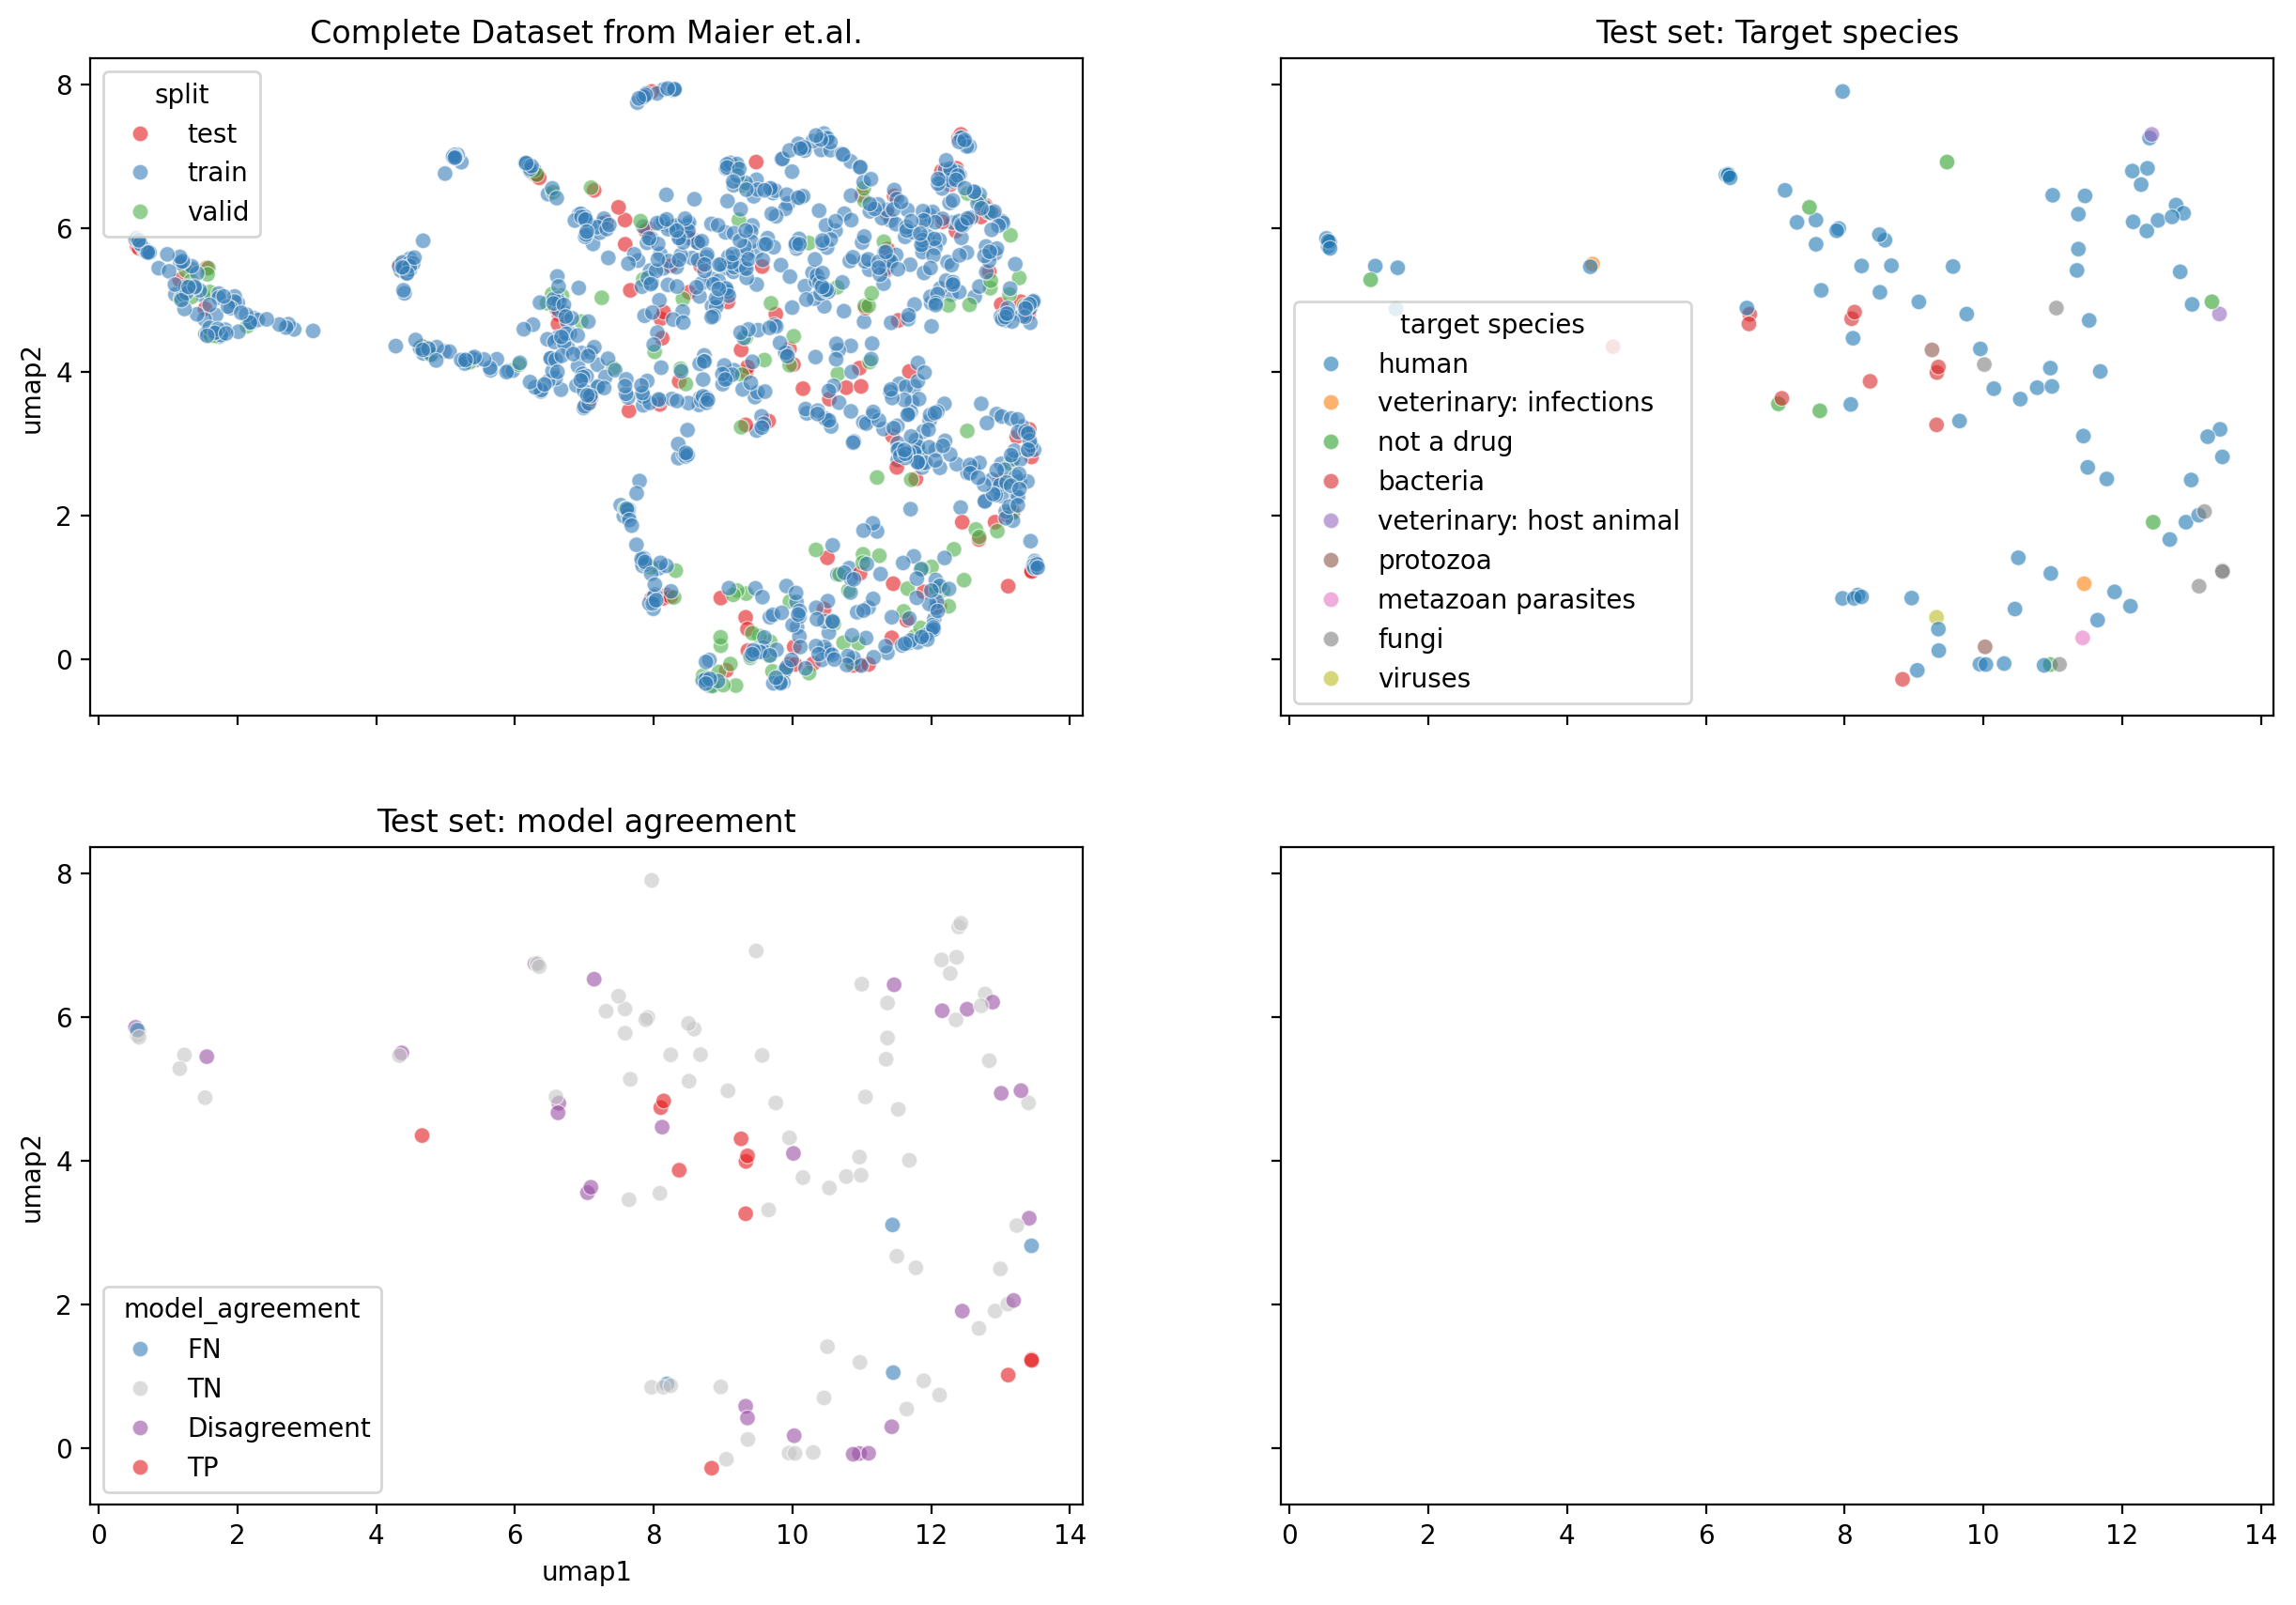

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="split", 
                  palette={"train":"#377eb8", "test": "#e41a1c", "valid":"#4daf4a"}, ax=ax1)
ax1.set(title="Complete Dataset from Maier et.al.")

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="target species", 
                ax=ax2)
ax2.set(title="Test set: Target species")

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="model_agreement", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "Disagreement": "#984ea3" }, ax=ax3)
ax3.set(title="Test set: model agreement")

[Text(0.5, 1.0, 'Test set: Chemical desciptors')]

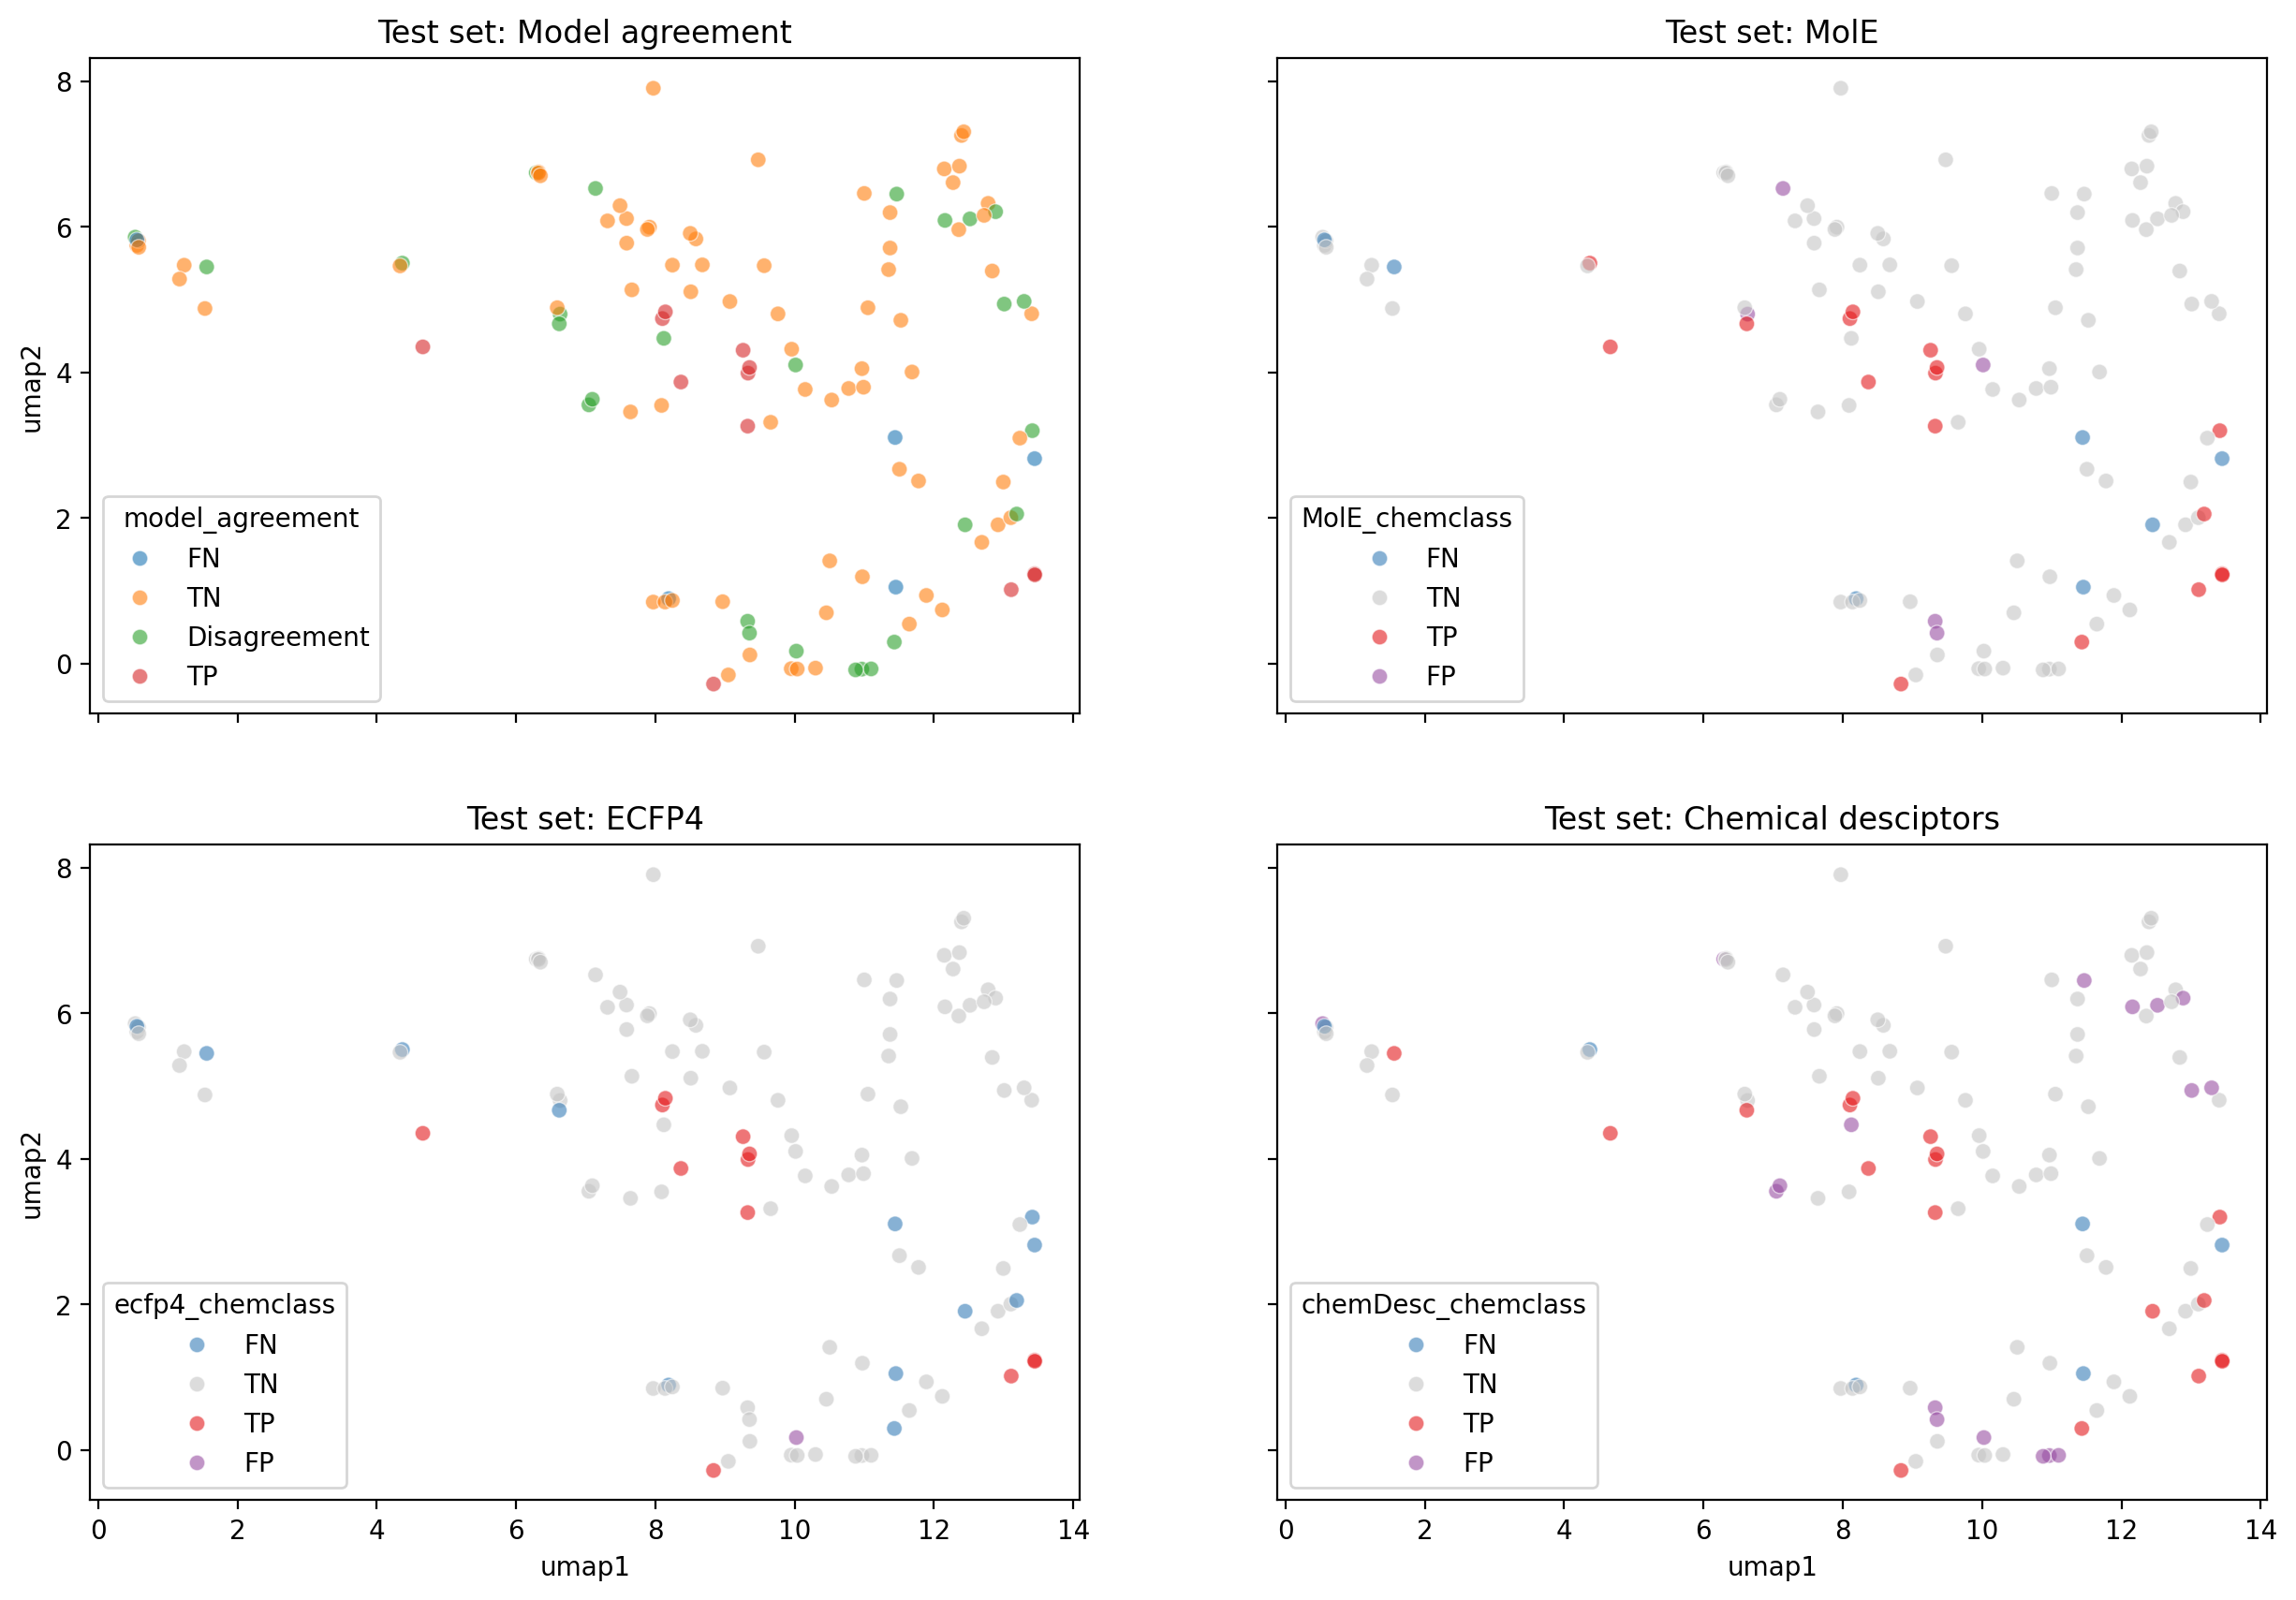

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="model_agreement", 
                ax=ax1)
ax1.set(title="Test set: Model agreement")

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="MolE_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax2)
ax2.set(title="Test set: MolE")

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="ecfp4_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax3)
ax3.set(title="Test set: ECFP4")

sns.scatterplot(data=mole_umap, x="umap1", y="umap2", alpha=0.6, hue="chemDesc_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax4)
ax4.set(title="Test set: Chemical desciptors")


In [51]:
reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=10, min_dist=0.15, metric="jaccard")

embedding = reducer.fit_transform(representation_dict["ecfp4"].loc[split_df.index].values)

fps_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = split_df.index)
                          
# Add chemical library origin
fps_umap = fps_umap.join(split_df).join(test_classification).reset_index(names="prestwick_ID")
fps_umap.head()

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,prestwick_ID,umap1,umap2,split,target species,model_agreement,MolE_chemclass,ecfp4_chemclass,chemDesc_chemclass
0,Prestw-1,6.648860,9.427593,test,human,FN,FN,FN,FN
1,Prestw-10,8.219444,11.681872,train,NaN,NaN,NaN,NaN,NaN
2,Prestw-100,14.051074,9.139538,test,human,TN,TN,TN,TN
3,Prestw-1000,1.665507,12.079626,train,NaN,NaN,NaN,NaN,NaN
4,Prestw-1001,10.092642,2.136757,train,NaN,NaN,NaN,NaN,NaN


[Text(0.5, 1.0, 'Test set: model agreement')]

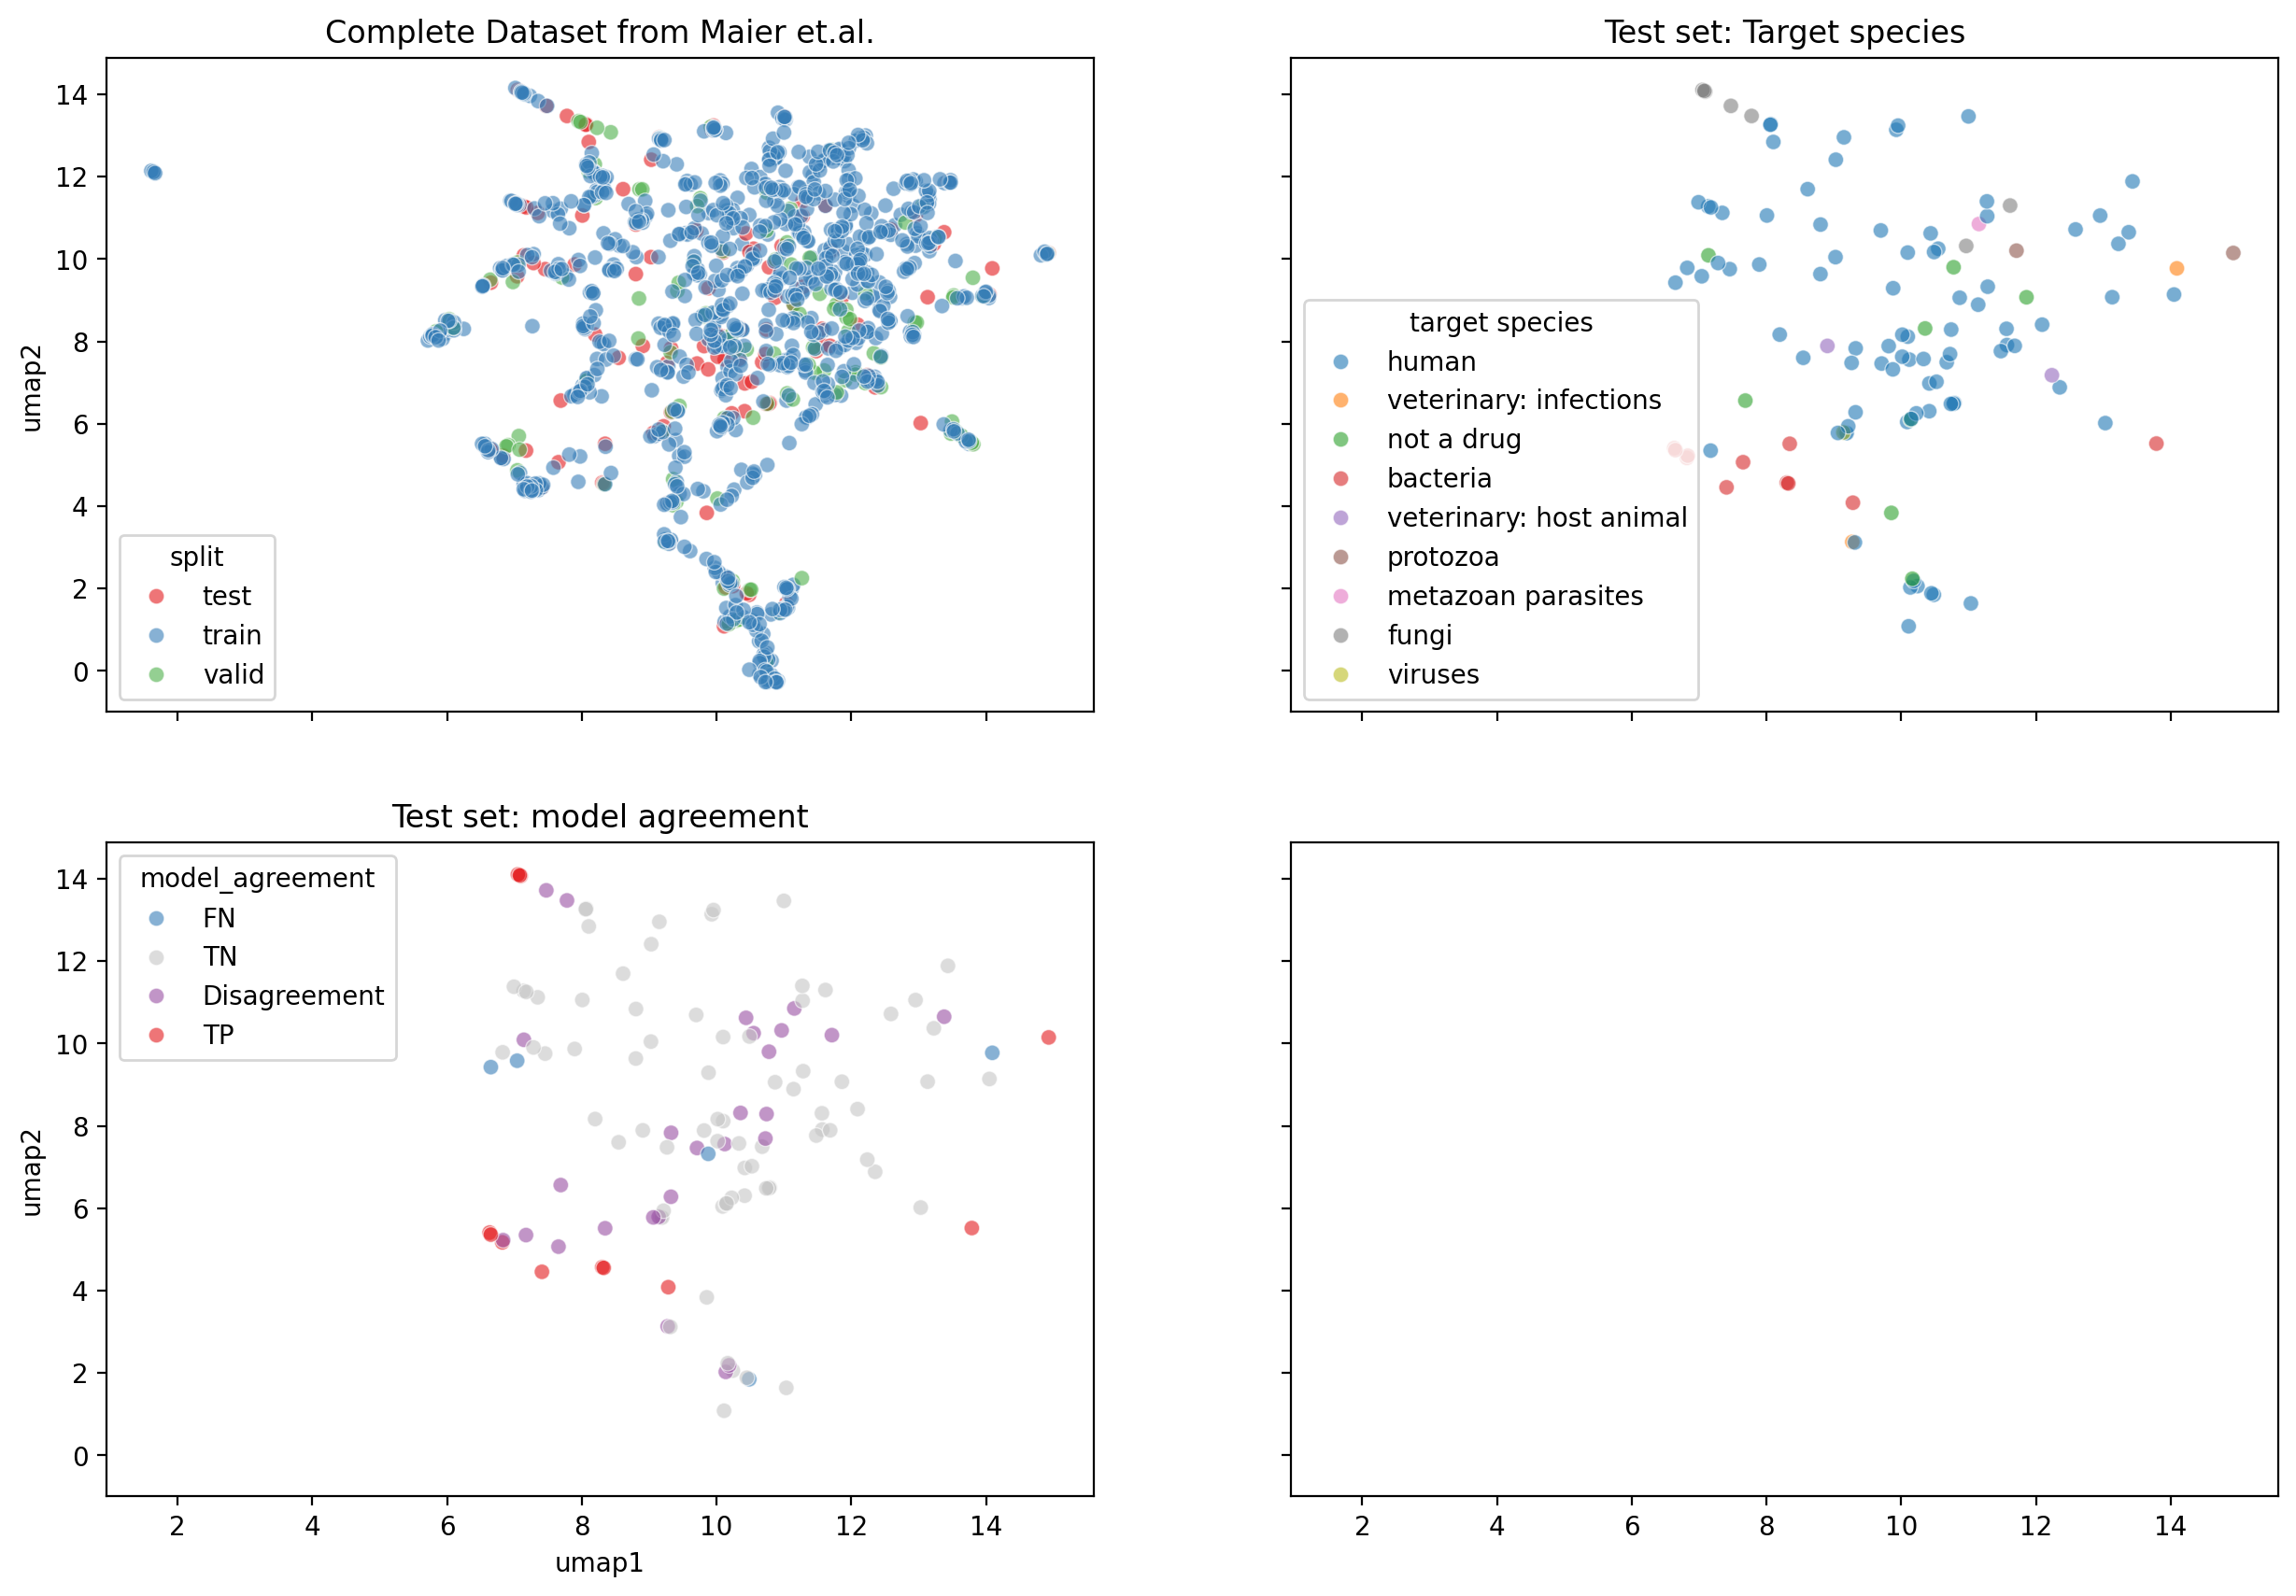

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="split", 
                  palette={"train":"#377eb8", "test": "#e41a1c", "valid":"#4daf4a"}, ax=ax1)
ax1.set(title="Complete Dataset from Maier et.al.")

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="target species", 
                ax=ax2)
ax2.set(title="Test set: Target species")

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="model_agreement", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "Disagreement": "#984ea3" }, ax=ax3)
ax3.set(title="Test set: model agreement")

[Text(0.5, 1.0, 'Test set: Chemical desciptors')]

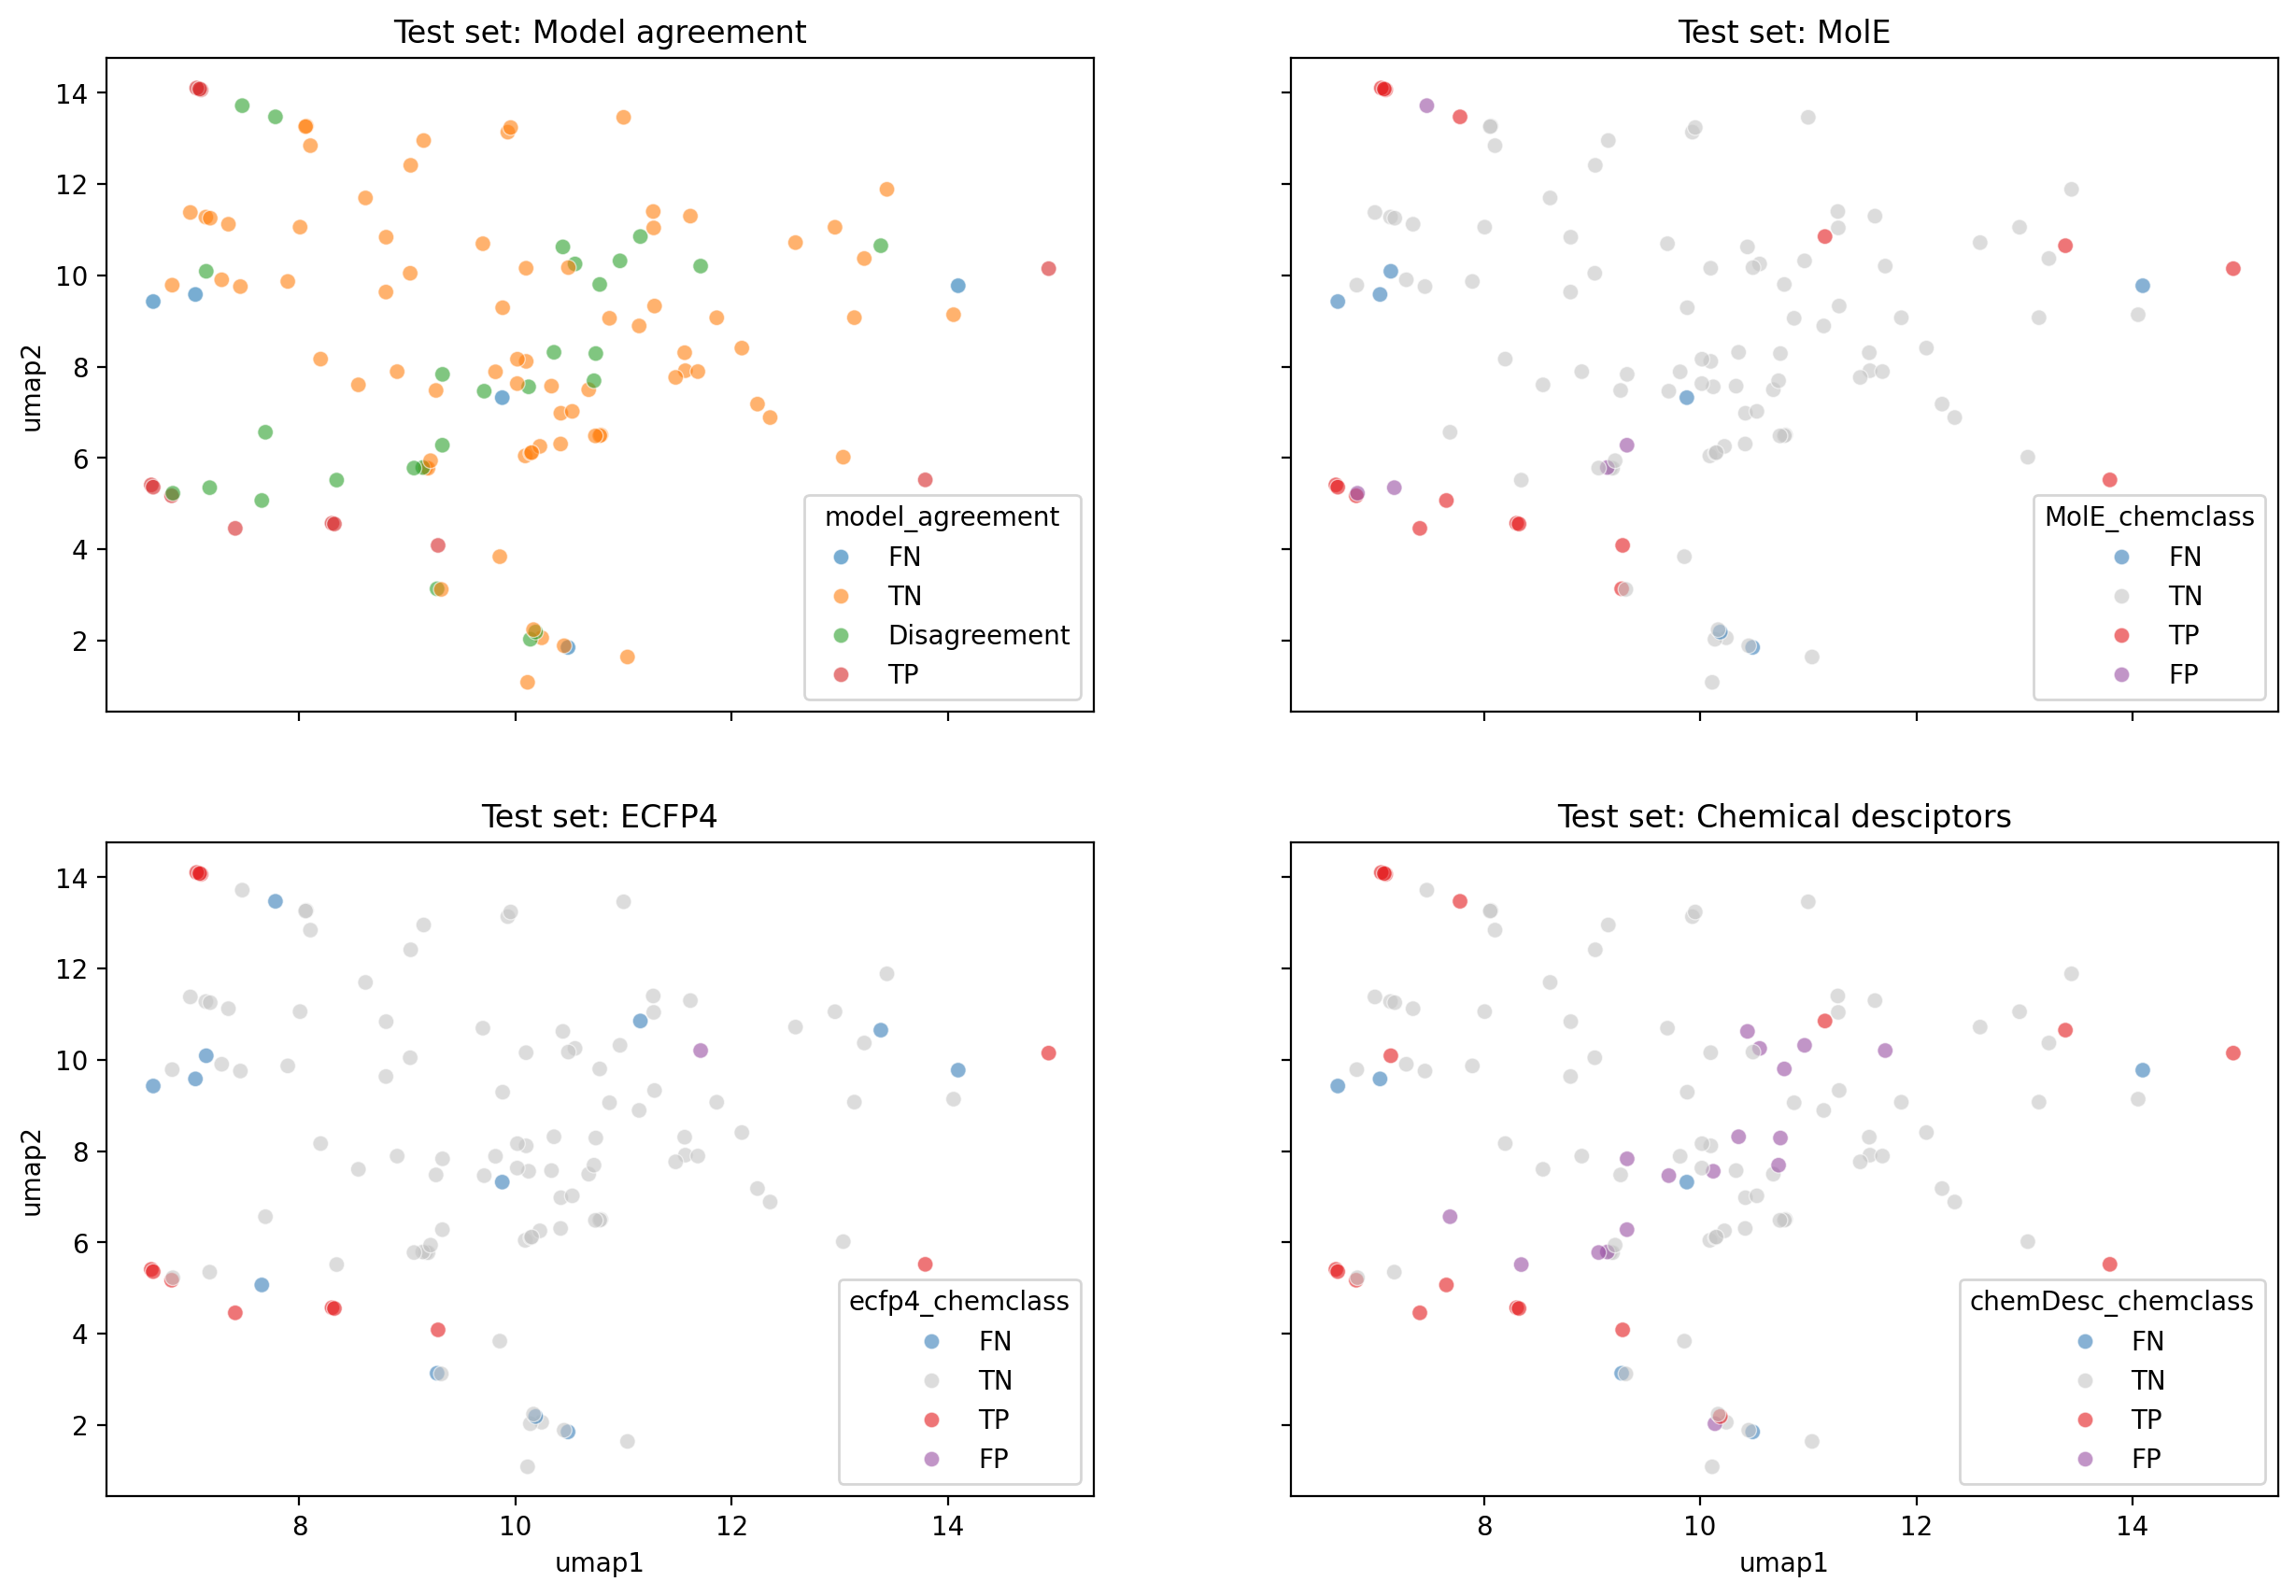

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="model_agreement", 
                ax=ax1)
ax1.set(title="Test set: Model agreement")

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="MolE_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax2)
ax2.set(title="Test set: MolE")

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="ecfp4_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax3)
ax3.set(title="Test set: ECFP4")

sns.scatterplot(data=fps_umap, x="umap1", y="umap2", alpha=0.6, hue="chemDesc_chemclass", 
                  palette={"TP": "#e41a1c", "FN": "#377eb8", "TN": "#C5C5C5", "FP": "#984ea3" }, ax=ax4)
ax4.set(title="Test set: Chemical desciptors")

## Write files

In [58]:
count_comparison.to_csv(os.path.join(OUTPUT_DIR, "prediction_comparison.tsv.gz"), sep='\t')

In [61]:
mole_umap.to_csv(os.path.join(OUTPUT_DIR, "umap_test_set_mole.tsv.gz"), index=False, sep='\t')

In [60]:
fps_umap.to_csv(os.path.join(OUTPUT_DIR, "umap_test_set_ecfp4.tsv.gz"), index=False, sep='\t')